In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sarim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

In [8]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [9]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [13]:
df.head(5)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [12]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 1.62 s


Text(0.5, 1.0, 'Dataset labels distribuition')

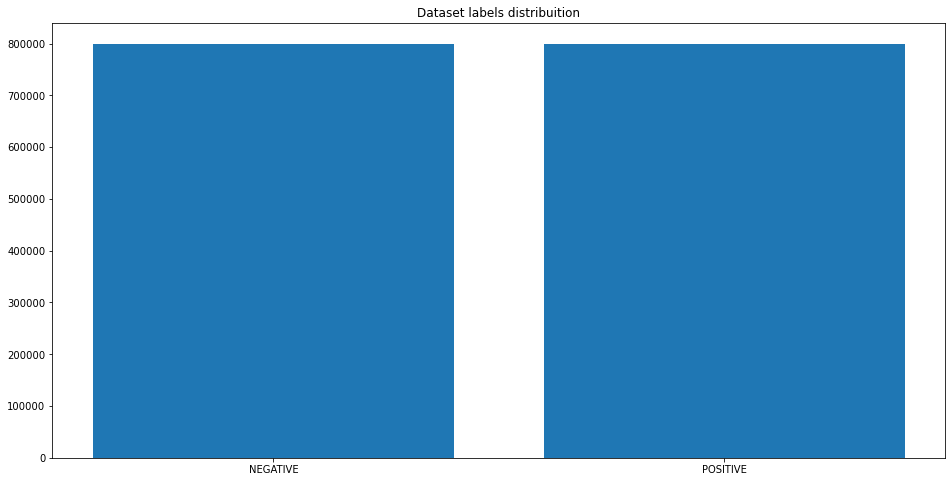

In [14]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [15]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [16]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [17]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 3min 54s


In [18]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [19]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 11.8 s


In [20]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [21]:
w2v_model.build_vocab(documents)

2021-04-10 13:26:40,716 : INFO : collecting all words and their counts
2021-04-10 13:26:40,724 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-04-10 13:26:40,812 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2021-04-10 13:26:40,916 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2021-04-10 13:26:41,035 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2021-04-10 13:26:41,203 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2021-04-10 13:26:41,307 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2021-04-10 13:26:41,411 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2021-04-10 13:26:41,489 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2021-04-10 13:26:41,649 : INFO : PROGRESS: at s

2021-04-10 13:26:48,258 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2021-04-10 13:26:48,363 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2021-04-10 13:26:48,529 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2021-04-10 13:26:48,681 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2021-04-10 13:26:48,804 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2021-04-10 13:26:48,964 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2021-04-10 13:26:49,044 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2021-04-10 13:26:49,162 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2021-04-10 13:26:49,313 : INFO : PROGRESS: at sentence #800000, processed 577088

In [22]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [23]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2021-04-10 13:27:22,498 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2021-04-10 13:27:23,619 : INFO : EPOCH 1 - PROGRESS: at 2.28% examples, 175156 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:27:24,625 : INFO : EPOCH 1 - PROGRESS: at 5.76% examples, 227766 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:27:25,673 : INFO : EPOCH 1 - PROGRESS: at 9.66% examples, 254103 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:27:26,691 : INFO : EPOCH 1 - PROGRESS: at 12.71% examples, 252122 words/s, in_qsize 16, out_qsize 1
2021-04-10 13:27:27,691 : INFO : EPOCH 1 - PROGRESS: at 15.19% examples, 242636 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:27:28,748 : INFO : EPOCH 1 - PROGRESS: at 18.76% examples, 248592 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:27:29,795 : INFO : EPOCH 1 - PROGRESS: at 22.33% examples, 253270 words/s, in_qsize 13, out_qsize 2
2021-04-10 13:27:30,834 : INFO : EPOCH 1 - PROGRESS: at

2021-04-10 13:28:24,047 : INFO : EPOCH 3 - PROGRESS: at 3.25% examples, 265494 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:28:25,149 : INFO : EPOCH 3 - PROGRESS: at 6.62% examples, 257283 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:28:26,235 : INFO : EPOCH 3 - PROGRESS: at 9.99% examples, 255806 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:28:27,253 : INFO : EPOCH 3 - PROGRESS: at 13.14% examples, 255830 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:28:28,277 : INFO : EPOCH 3 - PROGRESS: at 16.05% examples, 251747 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:28:29,290 : INFO : EPOCH 3 - PROGRESS: at 19.94% examples, 261867 words/s, in_qsize 14, out_qsize 1
2021-04-10 13:28:30,347 : INFO : EPOCH 3 - PROGRESS: at 22.43% examples, 252447 words/s, in_qsize 16, out_qsize 1
2021-04-10 13:28:31,371 : INFO : EPOCH 3 - PROGRESS: at 26.12% examples, 257808 words/s, in_qsize 14, out_qsize 1
2021-04-10 13:28:32,561 : INFO : EPOCH 3 - PROGRESS: at 30.35% examples, 261929 words/s, in

2021-04-10 13:29:25,011 : INFO : EPOCH - 4 : training on 9227204 raw words (8222624 effective words) took 31.2s, 263939 effective words/s
2021-04-10 13:29:26,214 : INFO : EPOCH 5 - PROGRESS: at 2.50% examples, 175217 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:29:27,246 : INFO : EPOCH 5 - PROGRESS: at 4.34% examples, 162106 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:29:28,321 : INFO : EPOCH 5 - PROGRESS: at 7.71% examples, 193114 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:29:29,361 : INFO : EPOCH 5 - PROGRESS: at 11.62% examples, 220439 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:29:30,455 : INFO : EPOCH 5 - PROGRESS: at 15.19% examples, 230485 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:29:31,487 : INFO : EPOCH 5 - PROGRESS: at 18.75% examples, 239284 words/s, in_qsize 16, out_qsize 3
2021-04-10 13:29:32,547 : INFO : EPOCH 5 - PROGRESS: at 22.01% examples, 240815 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:29:33,552 : INFO : EPOCH 5 - PROGRESS: at 25.80% exam

2021-04-10 13:30:28,077 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-10 13:30:28,077 : INFO : EPOCH - 6 : training on 9227204 raw words (8222643 effective words) took 31.8s, 258329 effective words/s
2021-04-10 13:30:29,158 : INFO : EPOCH 7 - PROGRESS: at 2.50% examples, 201366 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:30:30,313 : INFO : EPOCH 7 - PROGRESS: at 5.86% examples, 221258 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:30:31,327 : INFO : EPOCH 7 - PROGRESS: at 9.01% examples, 232376 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:30:32,368 : INFO : EPOCH 7 - PROGRESS: at 11.73% examples, 227302 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:30:33,384 : INFO : EPOCH 7 - PROGRESS: at 14.75% examples, 231228 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:30:34,413 : INFO : EPOCH 7 - PROGRESS: at 18.43% examples, 241100 words/s, in_qsize 14, out_qsize 1
2021-04-10 13:30:35,450 : INFO : EPOCH 7 - PROGRESS: at 22.00% examples, 247070 words/s, i

2021-04-10 13:31:29,690 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-10 13:31:29,690 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-10 13:31:29,690 : INFO : EPOCH - 8 : training on 9227204 raw words (8223075 effective words) took 32.0s, 257230 effective words/s
2021-04-10 13:31:30,751 : INFO : EPOCH 9 - PROGRESS: at 2.06% examples, 166205 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:31:31,777 : INFO : EPOCH 9 - PROGRESS: at 4.89% examples, 197372 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:31:32,817 : INFO : EPOCH 9 - PROGRESS: at 8.80% examples, 234024 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:31:33,836 : INFO : EPOCH 9 - PROGRESS: at 11.40% examples, 228853 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:31:34,826 : INFO : EPOCH 9 - PROGRESS: at 15.08% examples, 243105 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:31:36,050 : INFO : EPOCH 9 - PROGRESS: at 18.22% examples, 237134 words/s, in_qsize 14, out_qsize 1

2021-04-10 13:32:34,979 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-04-10 13:32:35,024 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-04-10 13:32:35,077 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-04-10 13:32:35,108 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-04-10 13:32:35,124 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-10 13:32:35,139 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-10 13:32:35,139 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-10 13:32:35,155 : INFO : EPOCH - 10 : training on 9227204 raw words (8222055 effective words) took 30.8s, 266585 effective words/s
2021-04-10 13:32:36,300 : INFO : EPOCH 11 - PROGRESS: at 2.06% examples, 151889 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:32:37,357 : INFO : EPOCH 11 - PROGRESS: at 4.56% examples, 172231 words/s, in_qsize 15, out_qsiz

2021-04-10 13:33:37,768 : INFO : EPOCH 12 - PROGRESS: at 68.53% examples, 233385 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:33:38,811 : INFO : EPOCH 12 - PROGRESS: at 71.13% examples, 232121 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:33:39,893 : INFO : EPOCH 12 - PROGRESS: at 73.94% examples, 231453 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:33:41,051 : INFO : EPOCH 12 - PROGRESS: at 76.55% examples, 229471 words/s, in_qsize 16, out_qsize 1
2021-04-10 13:33:42,051 : INFO : EPOCH 12 - PROGRESS: at 79.16% examples, 228918 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:33:43,144 : INFO : EPOCH 12 - PROGRESS: at 82.10% examples, 228603 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:33:44,316 : INFO : EPOCH 12 - PROGRESS: at 85.45% examples, 228863 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:33:45,374 : INFO : EPOCH 12 - PROGRESS: at 88.70% examples, 229657 words/s, in_qsize 16, out_qsize 1
2021-04-10 13:33:46,377 : INFO : EPOCH 12 - PROGRESS: at 92.28% examples, 231519

2021-04-10 13:34:39,442 : INFO : EPOCH 14 - PROGRESS: at 78.62% examples, 293657 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:34:40,453 : INFO : EPOCH 14 - PROGRESS: at 82.20% examples, 293663 words/s, in_qsize 13, out_qsize 2
2021-04-10 13:34:41,458 : INFO : EPOCH 14 - PROGRESS: at 85.88% examples, 293950 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:34:42,606 : INFO : EPOCH 14 - PROGRESS: at 90.00% examples, 293966 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:34:43,616 : INFO : EPOCH 14 - PROGRESS: at 93.70% examples, 294118 words/s, in_qsize 16, out_qsize 2
2021-04-10 13:34:44,644 : INFO : EPOCH 14 - PROGRESS: at 97.50% examples, 294575 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:34:45,066 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-04-10 13:34:45,127 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-04-10 13:34:45,153 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-04-10 13:34:45,206 : INFO : work

2021-04-10 13:35:40,144 : INFO : EPOCH 16 - PROGRESS: at 95.12% examples, 286283 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:35:41,208 : INFO : EPOCH 16 - PROGRESS: at 98.79% examples, 286357 words/s, in_qsize 12, out_qsize 0
2021-04-10 13:35:41,473 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-04-10 13:35:41,479 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-04-10 13:35:41,484 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-04-10 13:35:41,486 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-04-10 13:35:41,505 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-04-10 13:35:41,550 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-10 13:35:41,570 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-10 13:35:41,584 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-10 13:35:41,588 : INFO : EPOCH - 1

2021-04-10 13:36:40,455 : INFO : EPOCH 18 - PROGRESS: at 99.23% examples, 270526 words/s, in_qsize 6, out_qsize 4
2021-04-10 13:36:40,455 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-04-10 13:36:40,487 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-04-10 13:36:40,502 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-04-10 13:36:40,553 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-04-10 13:36:40,597 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-04-10 13:36:40,613 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-10 13:36:40,617 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-10 13:36:40,622 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-10 13:36:40,624 : INFO : EPOCH - 18 : training on 9227204 raw words (8222023 effective words) took 30.3s, 271113 effective words/s
2021-04-10 13:36:41

2021-04-10 13:37:36,144 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-04-10 13:37:36,182 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-04-10 13:37:36,188 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-10 13:37:36,209 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-10 13:37:36,213 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-10 13:37:36,216 : INFO : EPOCH - 20 : training on 9227204 raw words (8222239 effective words) took 27.5s, 298895 effective words/s
2021-04-10 13:37:37,265 : INFO : EPOCH 21 - PROGRESS: at 2.82% examples, 229106 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:37:38,283 : INFO : EPOCH 21 - PROGRESS: at 6.51% examples, 263040 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:37:39,305 : INFO : EPOCH 21 - PROGRESS: at 10.53% examples, 282773 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:37:40,424 : INFO : EPOCH 21 - PROGRESS: at 14.43%

2021-04-10 13:38:32,730 : INFO : EPOCH 23 - PROGRESS: at 3.14% examples, 254489 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:38:33,779 : INFO : EPOCH 23 - PROGRESS: at 6.95% examples, 275388 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:38:34,791 : INFO : EPOCH 23 - PROGRESS: at 10.64% examples, 283575 words/s, in_qsize 14, out_qsize 1
2021-04-10 13:38:35,800 : INFO : EPOCH 23 - PROGRESS: at 14.43% examples, 289932 words/s, in_qsize 14, out_qsize 1
2021-04-10 13:38:36,858 : INFO : EPOCH 23 - PROGRESS: at 18.32% examples, 292310 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:38:37,909 : INFO : EPOCH 23 - PROGRESS: at 22.11% examples, 293883 words/s, in_qsize 14, out_qsize 1
2021-04-10 13:38:39,062 : INFO : EPOCH 23 - PROGRESS: at 26.23% examples, 293475 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:38:40,104 : INFO : EPOCH 23 - PROGRESS: at 30.02% examples, 294163 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:38:41,123 : INFO : EPOCH 23 - PROGRESS: at 34.02% examples, 297607 w

2021-04-10 13:39:33,446 : INFO : EPOCH 25 - PROGRESS: at 21.24% examples, 285948 words/s, in_qsize 14, out_qsize 1
2021-04-10 13:39:34,472 : INFO : EPOCH 25 - PROGRESS: at 24.83% examples, 286325 words/s, in_qsize 16, out_qsize 1
2021-04-10 13:39:35,506 : INFO : EPOCH 25 - PROGRESS: at 28.40% examples, 285990 words/s, in_qsize 16, out_qsize 2
2021-04-10 13:39:36,507 : INFO : EPOCH 25 - PROGRESS: at 31.97% examples, 286748 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:39:37,588 : INFO : EPOCH 25 - PROGRESS: at 35.86% examples, 287906 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:39:38,651 : INFO : EPOCH 25 - PROGRESS: at 39.76% examples, 289269 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:39:39,707 : INFO : EPOCH 25 - PROGRESS: at 43.54% examples, 289561 words/s, in_qsize 16, out_qsize 1
2021-04-10 13:39:40,735 : INFO : EPOCH 25 - PROGRESS: at 47.43% examples, 291316 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:39:41,790 : INFO : EPOCH 25 - PROGRESS: at 51.21% examples, 291909

2021-04-10 13:40:33,721 : INFO : EPOCH 27 - PROGRESS: at 37.48% examples, 295663 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:40:34,722 : INFO : EPOCH 27 - PROGRESS: at 41.27% examples, 296933 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:40:35,735 : INFO : EPOCH 27 - PROGRESS: at 44.94% examples, 297107 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:40:36,876 : INFO : EPOCH 27 - PROGRESS: at 49.16% examples, 297886 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:40:37,964 : INFO : EPOCH 27 - PROGRESS: at 52.73% examples, 295956 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:40:39,080 : INFO : EPOCH 27 - PROGRESS: at 56.29% examples, 293666 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:40:40,083 : INFO : EPOCH 27 - PROGRESS: at 59.34% examples, 290842 words/s, in_qsize 14, out_qsize 1
2021-04-10 13:40:41,088 : INFO : EPOCH 27 - PROGRESS: at 62.46% examples, 288860 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:40:42,127 : INFO : EPOCH 27 - PROGRESS: at 66.15% examples, 289088

2021-04-10 13:41:34,714 : INFO : EPOCH 29 - PROGRESS: at 56.95% examples, 300286 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:41:35,776 : INFO : EPOCH 29 - PROGRESS: at 60.74% examples, 299668 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:41:36,793 : INFO : EPOCH 29 - PROGRESS: at 64.19% examples, 298604 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:41:37,807 : INFO : EPOCH 29 - PROGRESS: at 67.98% examples, 299084 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:41:38,825 : INFO : EPOCH 29 - PROGRESS: at 71.78% examples, 299581 words/s, in_qsize 14, out_qsize 1
2021-04-10 13:41:39,901 : INFO : EPOCH 29 - PROGRESS: at 75.78% examples, 299872 words/s, in_qsize 16, out_qsize 0
2021-04-10 13:41:40,904 : INFO : EPOCH 29 - PROGRESS: at 79.60% examples, 300325 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:41:41,954 : INFO : EPOCH 29 - PROGRESS: at 83.40% examples, 300179 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:41:42,974 : INFO : EPOCH 29 - PROGRESS: at 87.18% examples, 300399

2021-04-10 13:42:34,941 : INFO : EPOCH 31 - PROGRESS: at 76.11% examples, 298461 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:42:35,939 : INFO : EPOCH 31 - PROGRESS: at 79.71% examples, 298123 words/s, in_qsize 14, out_qsize 1
2021-04-10 13:42:37,000 : INFO : EPOCH 31 - PROGRESS: at 83.83% examples, 299260 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:42:38,004 : INFO : EPOCH 31 - PROGRESS: at 87.39% examples, 298817 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:42:39,034 : INFO : EPOCH 31 - PROGRESS: at 91.42% examples, 299781 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:42:40,098 : INFO : EPOCH 31 - PROGRESS: at 95.34% examples, 299923 words/s, in_qsize 15, out_qsize 0
2021-04-10 13:42:41,116 : INFO : EPOCH 31 - PROGRESS: at 98.79% examples, 299158 words/s, in_qsize 11, out_qsize 1
2021-04-10 13:42:41,224 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-04-10 13:42:41,239 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-04-10 13

Wall time: 15min 47s


(263122909, 295270528)

In [24]:
w2v_model.most_similar("love")

<ipython-input-24-9e1a4c826e7b>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v_model.most_similar("love")
2021-04-10 13:43:10,140 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5672188997268677),
 ('loves', 0.5611157417297363),
 ('loved', 0.5544396638870239),
 ('adore', 0.5128223299980164),
 ('amazing', 0.498919278383255),
 ('looove', 0.4805876910686493),
 ('awesome', 0.46082234382629395),
 ('loveee', 0.45311439037323),
 ('lovee', 0.4473338723182678),
 ('loving', 0.4309062957763672)]

In [25]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
Wall time: 1min 9s


In [26]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 1min 36s


In [27]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [28]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [29]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [30]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [31]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [32]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [33]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [34]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [35]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [36]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
  11/1125 [..............................] - ETA: 7:12:14 - loss: 0.6522 - accuracy: 0.6012

KeyboardInterrupt: 

In [ ]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [38]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

NameError: name 'history' is not defined

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)